# Introduction to the Retina project – D7046E @ LTU.SE

This notebook serves as a starting point and playground for investigating what the 1D Retina project is about.
The idea is that you should familiarize yourself with both projects and later on decide which project to focus on (retina/SNN or chatbot/ANN).

In [331]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Basic data generator

The following animation illustrates a simple motion detection task. A bright spot is moving across a one-dimensonal array of virtual receptor neurons.

![Concept illustration](https://drive.google.com/uc?export=view&id=1dc4TQ84ui5i9oVnGH9Au5sZfHKzt-2jd)

The task is to determine whether the pattern is moving and whether it is moving towards the left or right. The following code implements a basic spike data generator inspired by the animation above. For simplicity it is assumed that a bright spot is moving at constant speed back and forth, and that one spike is generated when the bright spot is passing over a receptor neuron.

In [332]:
# ####################################################################################################
# # Simulation parameters
# dt = 1e-4                    # Timestep
# t = np.arange(0,2000)*dt    # Simulation time array t
# num_receptors = 4           # Number of receptor neurons
# speed = 100                   # Speed of bright spot, number of receptor neurons passed per second
# ####################################################################################################

# plot_t = []                  # Time of spikes
# plot_n = []                  # Receptor neuron id's
# currtime = 0                 # Time when a spike is fired
# neuronid = 0                 # Neuron that fires a spike
# stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
# timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# # Make placeholders for spike time arrays to be used for SNN simulation
# spikes = []
# for i in range(num_receptors):
#     spikes.append([])

# # Generate and plot spikes from receptor neurons
# while currtime < t[-1]:
#     plot_t.append(currtime)
#     plot_n.append(neuronid)
#     spikes[neuronid].append(currtime)
#     if neuronid == 0 and stepdir == -1:
#         stepdir = 1
#     elif neuronid == (num_receptors-1) and stepdir == 1:
#         stepdir = -1
#     neuronid += stepdir
#     currtime += timestep
    
# # Plot spikes
# fig, ax = plt.subplots()
# rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
# ax.grid()



# Implement your first motion-detection SNN

There is a direction-selective network example in [Neuronify](https://ovilab.net/neuronify/), which is illustrated below. This network is designed so that the output neuron tends to fire a spike when the inputs are touched from right to left, but not when touched from left to right (with some limitations on the touching speed).

![First network implementation](https://drive.google.com/uc?export=view&id=1ZIyhUCtNebN1StlYCKEnC0qgXMZAF8d-)

Can you simulate this network using the code from SNN Exercise 1 and the input spikes provided by the data generator above? Can you modify the parameters of the simulated network so that it becomes direction selective?

If you succeed with this task then you have designed your first SNN vision system capable of basic motion detection!

**Note:** You need to complete SNN Exercise 1 to acquire the necessary background knowledge for this task.

In [333]:
def lif_neuron(I_inject, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3):
    # LIF neuron with a constant injection current
    return {
        'type'    : 'lif',
        'u'       : u_reset,                   # Membrane potential [Volt]
        'E_L'     : E_L,                       # Leakage resting potential [Volt]
        'u_reset' : u_reset,                   # Reset potential after spike [Volt]
        'u_thres' : u_thres,                   # Threshold for spike generation [Volt]
        'R'       : R,                         # Membrane resistance [Ohm]
        'tau_m'   : tau_m,                     # Membrane time constant [second]
        'I_inj'   : I_inject,                  # Injection current [Ampere]
    }

def lif_syn_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0, tau_syn=50e-3):
    # LIF neuron with dynamic synapses
    n = lif_neuron(I_inject, E_L, u_reset, u_thres, R, tau_m)
    n['tau_syn'] = tau_syn                     # Synapse time constant [second] (can also be an array)
    n['I_syn']   = np.zeros(num_synapses)      # Postsynaptic currents [Ampere]
    n['w_syn']   = np.zeros(num_synapses)      # Synaptic weights [Ampere]
    n['type']    = 'lif_syn'
    return n

def lif_stdp_neuron(num_synapses, E_L=-65e-3, u_reset=-65e-3, u_thres=-50e-3, R=90e6, tau_m=30e-3, I_inject=0,
                    tau_syn=50e-3, tau_pls=20e-3, tau_mns=20e-3, w_max=1e-9, w_min=1e-12, gamma=1):
    # LIF neuron with dynamic synapses and pair-based STDP
    n = lif_syn_neuron(num_synapses, E_L, u_reset, u_thres, R, tau_m, I_inject, tau_syn)
    n['x_pre']   = np.zeros(num_synapses)      # STDP trace of presynaptic spikes
    n['y_pst']   = 0                           # STDP trace of postsynaptic spikes (scalar, one neuron)
    n['tau_pls'] = tau_pls                     # STDP trace time constant [second] (can also be an array)
    n['tau_mns'] = tau_mns                     # STDP trace time constant [second] (can also be an array)
    n['w_max']   = w_max                       # Largest allowed value of synapse conductance
    n['w_min']   = w_min                       # Lowest allowed value of synapse conductance
    n['gamma']   = gamma                       # Learning rate parameter with soft bounds (w_min,w_max)
    n['type']    = 'lif_stdp'
    return n

def poisson_neuron(spike_frequency):
    # Random spike generator with Poisson distributed spike time intervals, see Section 7.2.1 in the book
    return {
        'type'      : 'poisson',
        'frequency' : spike_frequency          # Average spiking frequency
    }

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
    }






def integrate(dt, t, neurons):
    # Integrate the membrane potential, postsynaptic currents etc one timestep dt
    for n in neurons:
        if n['type'] == 'lif':
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*n['I_inj']) / n['tau_m']
            n['u'] += dt*dudt
        elif n['type'] in ['lif_syn','lif_stdp']:
            # Integrate array of postsynaptic currents, one current for each synapse
            didt = np.divide(-n['I_syn'], n['tau_syn'])
            n['I_syn'] += dt*didt
            # Integrate membrane potential
            dudt = (n['E_L'] - n['u'] + n['R']*(n['I_inj']+sum(n['I_syn']))) / n['tau_m']
            n['u'] += dt*dudt
            # Integrate local traces for pair-based plasticity
            if n['type'] == 'lif_stdp':
                n['x_pre'] -= dt*np.divide(n['x_pre'], n['tau_pls'])       # Eq 19.12
                n['y_pst'] -= dt*np.divide(n['y_pst'], n['tau_mns'])       # Eq 19.13
            
def spikegen(dt, t, neurons):
    # Implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif','lif_syn','lif_stdp']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'poisson':
            if np.random.rand() < dt*n['frequency']:
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
                
    return spikes

def update(dt, t, neurons, connections):
    # Update the state of a spiking neural network.
    # Refer to Exercise 3 for a reminder about how to set up connections between neurons.
    integrate(dt, t, neurons)
    spikes = spikegen(dt, t, neurons)

    # Update weights and STDP trace for each postsynaptic spike
    for spike in spikes:
        n = neurons[spike]
        if n['type'] in ['lif_stdp']:
            n['y_pst'] += 1                                         # Eq 19.13
            for i,w in enumerate(n['w_syn']):
                if w > 0:                                           # Excitatory synapses
                    Aplus = n['gamma']*(n['w_max'] - n['w_syn'][i]) # Eq 19.4
                    n['w_syn'][i] += dt*Aplus*n['x_pre'][i]         # Eq 19.14
    
    # Update synapse currents, weights and STDP traces for each presynaptic spike
    for (post, syn, pre) in connections:
        for spike in spikes:
            if spike == pre:
                n = neurons[post]
                
                if n['type'] not in ['lif_syn', 'lif_stdp']:
                    print('Error: Spike sent to neuron type without synapses')
                
                # Update synapse currents
                if n['type'] in ['lif_syn','lif_stdp']:
                    n['I_syn'][syn] += n['w_syn'][syn]
                    
                # Update STDP trace and weight
                if n['type'] in ['lif_stdp']:
                    n['x_pre'][syn] += 1                                   # Eq 19.12
                    if n['w_syn'][syn] > 0:                                # Excitatory synapses
                        Aminus = n['gamma']*(n['w_min'] - n['w_syn'][syn]) # Eq 19.4
                        n['w_syn'][syn] += dt*Aminus*n['y_pst']            # Eq 19.14
    
    return spikes



spikes [[0, 0.2222222222222222, 0.4444444444444444, 0.6666666666666667, 0.8888888888888891], [0.1111111111111111, 0.3333333333333333, 0.5555555555555556, 0.7777777777777779]]
num_receptors 2
num_stages 1
spike_gens_start 0
input_start 2
temporals_start 4
lateral_inhibitors_start 6
repeat_inhibitors_start 8
stage_outputs_start 10
total_outputs_start 12
len(neurons) 14


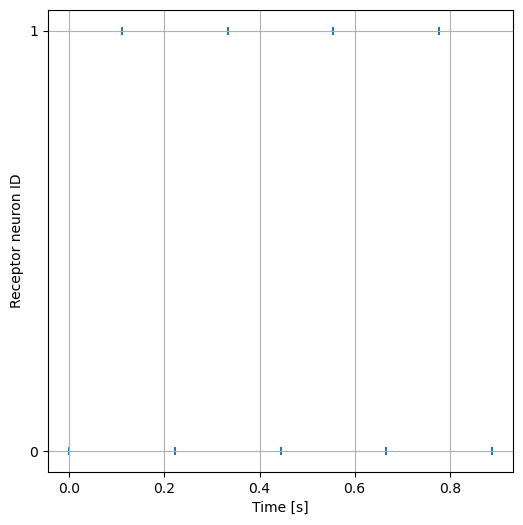

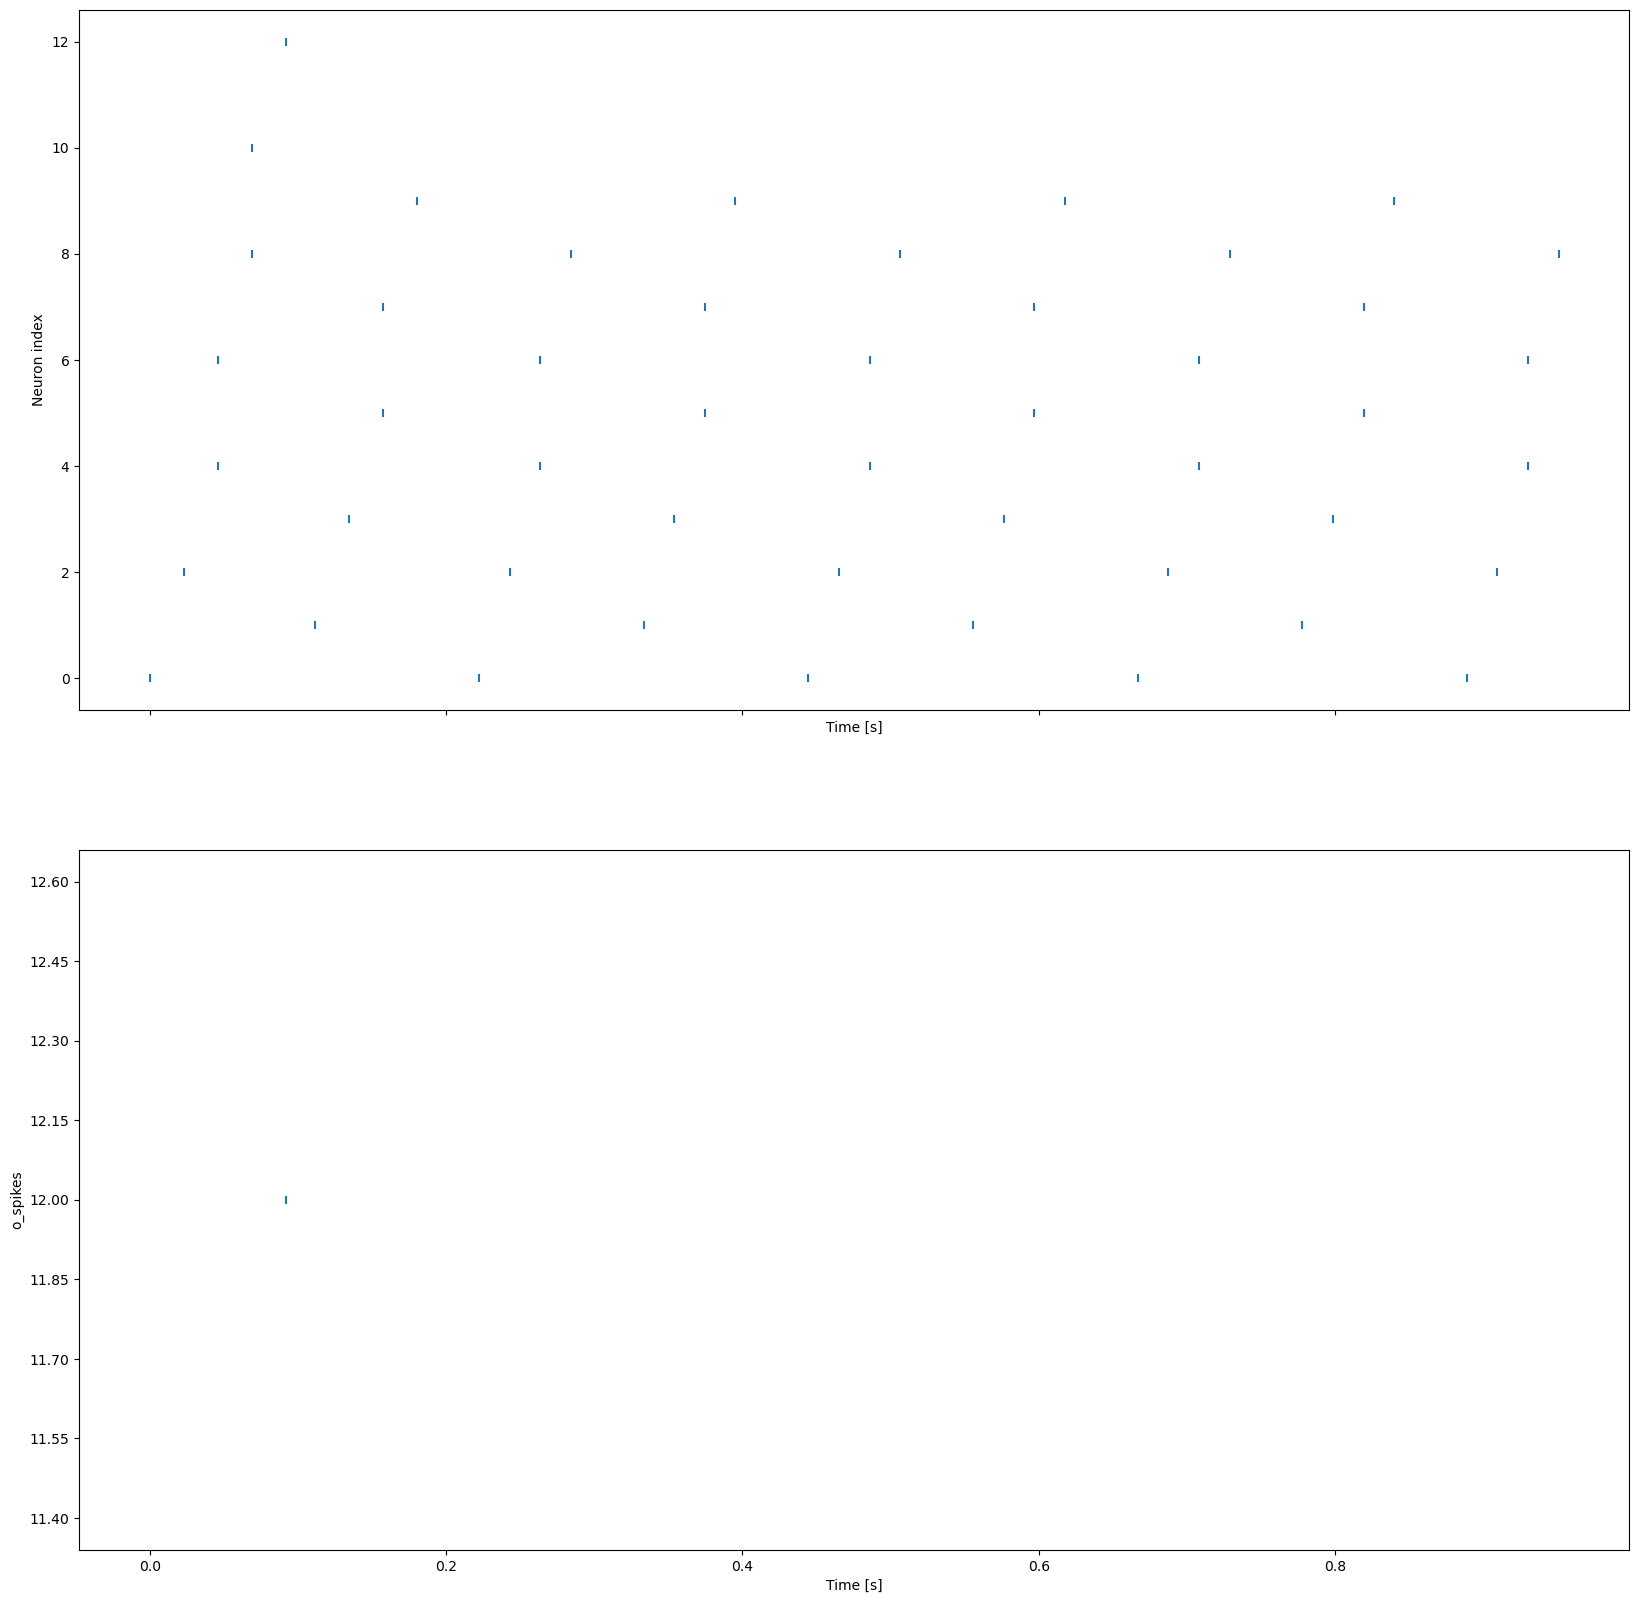

In [334]:
# Simulation parameters
dt = 1e-4                    # Timestep
num_receptors = 2           # Number of receptor neurons
speed = 10                   # Speed of bright spot, number of receptor neurons passed per second
sim_time = 1



def generate_and_plot_spikes(dt, num_receptors, speed, time_to_generate_spikes):
    t = np.arange(0,time_to_generate_spikes * 1/dt)*dt    # Simulation time array t
    plot_t = []                  # Time of spikes
    plot_n = []                  # Receptor neuron id's
    currtime = 0                 # Time when a spike is fired
    neuronid = 0                 # Neuron that fires a spike
    stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
    timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

    # Make placeholders for spike time arrays to be used for SNN simulation
    spikes = []
    for i in range(num_receptors):
        spikes.append([])

    # Generate and plot spikes from receptor neurons
    while currtime < t[-1]:
        plot_t.append(currtime)
        plot_n.append(neuronid)
        spikes[neuronid].append(currtime)
        if neuronid == 0 and stepdir == -1:
            stepdir = 1
        elif neuronid == (num_receptors-1) and stepdir == 1:
            stepdir = -1
        neuronid += stepdir
        currtime += timestep
        
    # Plot spikes
    fig, ax = plt.subplots()
    rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
    ax.grid()
    return spikes




spikes = generate_and_plot_spikes(dt, num_receptors, speed, sim_time)
# spikes = []
# spikes.append([])
# spikes.append([0])

print(f'spikes {spikes}')



spike_gens = []
inputs = []
temporals = []
lateral_inhibitors = []
repeat_inhibitors = []
stage_outputs = []

total_outputs = []

print(f'num_receptors {num_receptors}')
# for (i, spike) in enumerate(spikes):
#     s.append(spike_generator(spikes[i]))
#     inputs.append(lif_syn_neuron(1))
#     if i != len(spikes) - 1:
#         fi.append(lif_syn_neuron(1))
#         r.append(lif_syn_neuron(2))



assert(num_receptors >= 2)
assert(num_receptors % 2 == 0)
assert(num_receptors <= len(spikes))

num_stages = num_receptors // 2
print(f'num_stages {num_stages}')


# add neurons per instance
for i in range(num_receptors):

    spike_gens.append(spike_generator(spikes[i]))
    inputs.append(lif_syn_neuron(1))

    temporals.append(lif_syn_neuron(1))
    lateral_inhibitors.append(lif_syn_neuron(1))

    repeat_inhibitors.append(lif_syn_neuron(1))
    stage_outputs.append(lif_syn_neuron(3))




total_outputs.append(lif_syn_neuron(num_stages))
total_outputs.append(lif_syn_neuron(num_stages))


for i in range(num_stages):
    inputs[i]['w_syn'][0] = 400e-12
    inputs[i + 1]['w_syn'][0] = 400e-12


    temporals[i]['w_syn'][0] = 400e-12
    temporals[i + 1]['w_syn'][0] = 400e-12


    lateral_inhibitors[i]['w_syn'][0] = 400e-12
    lateral_inhibitors[i + 1]['w_syn'][0] = 400e-12


    repeat_inhibitors[i]['w_syn'][0] = 400e-12
    repeat_inhibitors[i +1 ]['w_syn'][0] = 400e-12


    repeat_inhibition_synapse_weight = -500e-12
    lateral_inhibition_weight = -200e-12

    stage_outputs[i]['w_syn'][0] = repeat_inhibition_synapse_weight
    stage_outputs[i]['w_syn'][1] = 400e-12
    stage_outputs[i]['w_syn'][2] = lateral_inhibition_weight


    stage_outputs[i + 1]['w_syn'][0] = lateral_inhibition_weight
    stage_outputs[i + 1]['w_syn'][1] = 400e-12
    stage_outputs[i + 1]['w_syn'][2] = repeat_inhibition_synapse_weight


    total_outputs[0]['w_syn'][i] = 400e-12
    total_outputs[1]['w_syn'][i] = 400e-12






neurons = []

spike_gens_start = len(neurons)
neurons.extend(spike_gens)

input_start = len(neurons)
neurons.extend(inputs)

temporals_start = len(neurons)
neurons.extend(temporals)

lateral_inhibitors_start = len(neurons)
neurons.extend(lateral_inhibitors)

repeat_inhibitors_start = len(neurons)
neurons.extend(repeat_inhibitors)

stage_outputs_start = len(neurons)
neurons.extend(stage_outputs)

total_outputs_start = len(neurons)
neurons.extend(total_outputs)




print(f'spike_gens_start {spike_gens_start}')
print(f'input_start {input_start}')

print(f'temporals_start {temporals_start}')
print(f'lateral_inhibitors_start {lateral_inhibitors_start}')

print(f'repeat_inhibitors_start {repeat_inhibitors_start}')
print(f'stage_outputs_start {stage_outputs_start}')

print(f'total_outputs_start {total_outputs_start}')

print(f'len(neurons) {len(neurons)}')

connections = []


for i in range(0, num_stages):

    connections.append([input_start + i, 0, spike_gens_start + i])
    connections.append([input_start + i + 1, 0, spike_gens_start + i + 1])


    connections.append([temporals_start + i, 0, input_start + i])
    connections.append([temporals_start + i + 1, 0, input_start + i + 1])


    connections.append([lateral_inhibitors_start + i, 0, input_start + i])
    connections.append([lateral_inhibitors_start + i + 1 , 0, input_start + i + 1])


    connections.append([repeat_inhibitors_start + i, 0, temporals_start + i])
    connections.append([repeat_inhibitors_start + i + 1, 0, temporals_start + i + 1])




    connections.append([stage_outputs_start + i, 0, repeat_inhibitors_start + i])
    connections.append([stage_outputs_start + i, 1, temporals_start + i])
    connections.append([stage_outputs_start + i, 2, lateral_inhibitors_start + i + 1])


    connections.append([stage_outputs_start + i + 1, 0, lateral_inhibitors_start + i])
    connections.append([stage_outputs_start + i + 1, 1, temporals_start + i + 1])
    connections.append([stage_outputs_start + i + 1, 2, repeat_inhibitors_start + i + 1])



for i in range(0, num_stages):
    connections.append([total_outputs_start+0, 0, stage_outputs_start + i])
    connections.append([total_outputs_start+1, 0, stage_outputs_start + i + 1])

t = 0

o_spike = []
ot_spike = []

t_spike = []
n_spike = []

while t < sim_time:

    spikes = update(dt, t, neurons, connections)

    for s in spikes:
        t_spike.append(t)
        n_spike.append(s)
        if s == total_outputs_start+0:
            ot_spike.append(t)
            o_spike.append(s)
        elif s == total_outputs_start+1:
            ot_spike.append(t)
            o_spike.append(s)

    t += dt


plt.rcParams['figure.figsize'] = [20, 20]
fig,(ax1,ax2) = plt.subplots(2,1, sharex=True)
rasterplot(ax1, t_spike, n_spike,'Time [s]','Neuron index')
rasterplot(ax2, ot_spike, o_spike,'Time [s]','o_spikes')


# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike t2me arrays produced by the data generator code above.

# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

# Further project work 

The challenge for the **1D Retina project** is to develop a more advanced vision system for (1D) motion classification, which is not limited to one specific pattern like the bright spot in the basic data generator above.

For example, you could consider using an open image dataset for training, validation and testing. For testing, the output of a webcam could optionally be considered. The delta modulator concept introduced in SNN Exercise 1 could potentially be used to convert pixel intensities to spikes. Optionally, you can use a [DAVIS346 neuromorphic vision sensor](https://inivation.github.io/inivation-docs/Hardware%20user%20guides/User_guide_-_DAVIS346.html) to record your own dataset.

Some inspiration for the SNN network architecture and training protocol can be obtained also from SNN Exercise 2. The [Reichardt Detector](https://en.wikipedia.org/wiki/Motion_perception#The_Reichardt-Hassenstein_model) is one starting point. For further inspiration, consider for example [motion detection in insects](https://link.springer.com/content/pdf/10.1007/s00359-019-01375-9.pdf).

In addition to considering differnt types of receptor models and SNN architectures for efficient and reliable motion classification, you can consider using other SNN simulators like [Brian2](https://brian2.readthedocs.io). Optionally you can consider using accelerators like [Brian2GeNN](https://brian2genn.readthedocs.io/en/stable/introduction/).

The possibilities for exploration are endless! How does the human retina work?